In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet50
import json
import os
from PIL import Image
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
import numpy as np

In [2]:
# Mount Google Drive (if needed)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Data paths (adjust these to your actual paths)
image_dir_train = "/content/drive/MyDrive/SubtleDifference/Train-Val-DS/train"
image_dir_val = "/content/drive/MyDrive/SubtleDifference/Train-Val-DS/val"
train_capt_annotations = "/content/drive/MyDrive/SubtleDifference/train-val-annotations/capt_train_annotations.json"
train_class_annotations = "/content/drive/MyDrive/SubtleDifference/train-val-annotations/class_train_annotation.json"
val_capt_annotations = "/content/drive/MyDrive/SubtleDifference/train-val-annotations/capt_val_annotations.json"
val_class_annotations = "/content/drive/MyDrive/SubtleDifference/train-val-annotations/class_val_annotation.json"

In [4]:
class SubtleDiffDataset(Dataset):
    def __init__(self, image_dir, capt_annotation_file, class_annotation_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.capt_annotations = {}
        self.class_annotations = {}

        # Load caption annotations
        try:
            with open(capt_annotation_file, 'r') as f:
                capt_data = json.load(f)
                for item in capt_data:
                    self.capt_annotations[item['name']] = item
        except (FileNotFoundError, json.JSONDecodeError) as e:
            print(f"Error loading capt annotations: {e}")

        # Load class annotations
        try:
            with open(class_annotation_file, 'r') as f:
                class_data = json.load(f)
                for item in class_data:
                    self.class_annotations[item['name']] = item
        except (FileNotFoundError, json.JSONDecodeError) as e:
            print(f"Error loading class annotations: {e}")

        self.image_pairs = list(self.capt_annotations.keys())  # List of pair names

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        pair_name_with_object = self.image_pairs[idx]  # e.g., "v2_1287"

        # Updated regex to extract pair name correctly
        match = re.match(r"(train|val)/(v[1-3]_\d+)", pair_name_with_object)
        if match:
            pair_name = match.group(2)  # Extracts "v2_1287"
        else:
            print(f"Warning: Invalid pair name format: {pair_name_with_object}")
            return None

        # Construct image paths for 'before' and 'after' images
        after_image_path = os.path.join(self.image_dir, f"{pair_name}_after.png")
        before_image_path = os.path.join(self.image_dir, f"{pair_name}_before.png")

        # Try to load images with error handling
        try:
            if os.path.exists(after_image_path) and os.path.exists(before_image_path):
                after_image = Image.open(after_image_path).convert('RGB')
                before_image = Image.open(before_image_path).convert('RGB')
            else:
                print(f"Warning: Missing image pair: {pair_name_with_object}")
                return None  # Immediately return None if files are missing
        except FileNotFoundError:
            print(f"Error: Image file not found for pair: {pair_name}")
            return None  # Also return None in case of an exception

        # Extract labels directly in __getitem__
        capt_labels = []
        class_labels = []

        # Extract labels for caption annotations (capt)
        capt_data = self.capt_annotations.get(pair_name_with_object, {})
        for attr_key in ['color', 'shape', 'texture']:
            attribute_data = next((attr for attr in capt_data.get('attributes', []) if attr.get('key') == attr_key), None)
            if attribute_data:
                if 'answer' in attribute_data:  # 'class' JSON
                    capt_labels.append(1 if attribute_data['answer'] == 'After' else 0)
                elif 'value' in attribute_data:  # 'capt' JSON
                    match = re.search(r"(Image|image)\s+2\s+is", attribute_data['value'])
                    if match:
                        capt_labels.append(1)  # Image 2 is mentioned, so label is 1
                    else:
                        capt_labels.append(0)  # Image 2 is NOT mentioned, so label is 0
                else:
                    capt_labels.append(0)
            else:
                capt_labels.append(0)

        # Extract labels for class annotations
        class_data = self.class_annotations.get(pair_name_with_object, {})
        for attr_key in ['color', 'shape', 'texture']:
            attribute_data = next((attr for attr in class_data.get('attributes', []) if attr.get('key') == attr_key), None)
            if attribute_data:
                if 'answer' in attribute_data:  # 'class' JSON
                    class_labels.append(1 if attribute_data['answer'] == 'After' else 0)
                elif 'value' in attribute_data:  # 'capt' JSON
                    match = re.search(r"(Image|image)\s+2\s+is", attribute_data['value'])
                    if match:
                        class_labels.append(1)  # Image 2 is mentioned, so label is 1
                    else:
                        class_labels.append(0)  # Image 2 is NOT mentioned, so label is 0
                else:
                    class_labels.append(0)
            else:
                class_labels.append(0)

        # Combine or choose labels based on your logic (e.g., prioritize class labels if available)
        labels = class_labels if class_labels else capt_labels

        # Convert labels to tensor
        labels = torch.tensor(labels, dtype=torch.float32)

        # Apply transformations
        if self.transform:
            after_image = self.transform(after_image)
            before_image = self.transform(before_image)

        return after_image, before_image, labels, pair_name


transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize 1024x1024 images to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),      # Randomly rotate images by up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, saturation, and hue
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for ResNet
])



In [5]:
# Define the DBT block
class DBTBlock(nn.Module):
    def __init__(self, in_channels, groups):
        super(DBTBlock, self).__init__()
        self.groups = groups
        assert in_channels % groups == 0, "in_channels must be divisible by groups"
        self.group_size = in_channels // groups

        self.linear = nn.Linear(self.group_size, self.group_size, bias=False)
        self.adaptive_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        x = x.view(batch_size, self.groups, self.group_size, height, width)

        out = []
        for i in range(self.groups):
            group_tensor = x[:, i, :, :, :]
            pooled_tensor = self.adaptive_pool(group_tensor).squeeze(3).squeeze(2)
            group_out = self.linear(pooled_tensor)
            group_out = group_out.unsqueeze(2).unsqueeze(3).expand_as(group_tensor)
            out.append(group_out)

        x = torch.stack(out, dim=1).view(batch_size, channels, height, width)
        return x

class DBTResNet50(nn.Module):
    def __init__(self, num_classes=3):
        super(DBTResNet50, self).__init__()
        self.resnet = resnet50(weights='IMAGENET1K_V1')
        self.dbt = DBTBlock(in_channels=2048, groups=8)
        self.dropout = nn.Dropout(0.5)  # Add dropout with 50% probability
        self.fc = nn.Linear(4096, num_classes)

    def forward(self, x1, x2):
        def extract_features(x):
            x = self.resnet.conv1(x)
            x = self.resnet.bn1(x)
            x = self.resnet.relu(x)
            x = self.resnet.maxpool(x)
            x = self.resnet.layer1(x)
            x = self.resnet.layer2(x)
            x = self.resnet.layer3(x)
            x = self.resnet.layer4(x)
            x = self.dbt(x)
            x = self.resnet.avgpool(x)
            return torch.flatten(x, 1)

        x1 = extract_features(x1)
        x2 = extract_features(x2)
        x = torch.cat((x1, x2), dim=1)
        x = self.dropout(x)  # Apply dropout before the final layer
        return self.fc(x)

In [6]:
# Reinitialize the dataset and dataloader only once
train_dataset = SubtleDiffDataset(image_dir_train, train_capt_annotations, train_class_annotations, transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: tuple(zip(*[b for b in x if b is not None])))

val_dataset = SubtleDiffDataset(image_dir_val, val_capt_annotations, val_class_annotations, transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: tuple(zip(*[b for b in x if b is not None])))


In [7]:
from torch.optim.lr_scheduler import StepLR # Import StepLR
# Model, Loss, Optimizer
model = DBTResNet50(num_classes=3).cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)  # Add weight decay
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR by a factor of 0.1 every 5 epochs


In [8]:
# For plotting and tracking
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
all_train_labels = []
all_train_preds = []
all_val_labels = []
all_val_preds = []

In [9]:
# To track metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
precision, recall, f1 = [], [], []
roc_auc_scores = []

In [10]:
# Training Loop (with improvements)
num_epochs = 10
best_val_loss = float('inf')
patience = 3  # Number of epochs to wait for improvement
epochs_without_improvement = 0
# Modify the training loop to track and store metrics
for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    all_labels, all_preds = [], []

    for after_images, before_images, labels, _ in train_loader:
        if after_images is None:  # Check if the entire batch is None
            continue
        after_images = torch.stack(after_images).cuda()
        before_images = torch.stack(before_images).cuda()
        labels = torch.stack(labels).cuda()

        optimizer.zero_grad()
        outputs = model(after_images, before_images)

        loss = criterion(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        predicted = torch.sigmoid(outputs) > 0.5
        correct += (predicted == labels).sum().item()
        total += labels.numel()

        # Store for later evaluation
        all_labels.append(labels.cpu().numpy())
        all_preds.append(predicted.cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Flatten the lists
    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)

        # Compute precision, recall, and F1 score
    precision.append(precision_score(all_labels, all_preds, average='micro')) # Changed average to 'micro'
    recall.append(recall_score(all_labels, all_preds, average='micro')) # Changed average to 'micro'
    f1.append(f1_score(all_labels, all_preds, average='micro')) # Changed average to 'micro'

    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")
    # Add this at the end of the training loop (inside the epoch loop):
    scheduler.step()

Epoch [1/10]
Training Loss: 0.6956, Training Accuracy: 52.34%
Epoch [2/10]
Training Loss: 0.6544, Training Accuracy: 61.24%
Epoch [3/10]
Training Loss: 0.5894, Training Accuracy: 69.20%
Epoch [4/10]
Training Loss: 0.4897, Training Accuracy: 76.44%
Epoch [5/10]
Training Loss: 0.3912, Training Accuracy: 82.57%
Epoch [6/10]
Training Loss: 0.2574, Training Accuracy: 91.31%
Epoch [7/10]
Training Loss: 0.2127, Training Accuracy: 93.49%
Epoch [8/10]
Training Loss: 0.1793, Training Accuracy: 95.71%
Epoch [9/10]
Training Loss: 0.1565, Training Accuracy: 96.05%
Epoch [10/10]
Training Loss: 0.1368, Training Accuracy: 96.90%


In [11]:
# Validation Loop for 10 Epochs
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Validation Epoch [{epoch+1}/{num_epochs}]")

    # Validation loop with performance metrics
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    val_labels, val_preds = [], []

    with torch.no_grad():
        for after_images, before_images, labels, _ in val_loader:
            if after_images is None:
                continue
            after_images = torch.stack(after_images).cuda()
            before_images = torch.stack(before_images).cuda()
            labels = torch.stack(labels).cuda()

            outputs = model(after_images, before_images)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            predicted = torch.sigmoid(outputs) > 0.5
            correct += (predicted == labels).sum().item()
            total += labels.numel()

            val_labels.append(labels.cpu().numpy())
            val_preds.append(predicted.cpu().numpy())

    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Flatten the validation lists
    val_labels = np.concatenate(val_labels, axis=0) # Concatenate the list of arrays into a single array
    val_preds = np.concatenate(val_preds, axis=0) # Concatenate the list of arrays into a single array
    val_labels_flat = val_labels.ravel()
    val_preds_flat = val_preds.ravel()
    fpr, tpr, thresholds = roc_curve(val_labels_flat, val_preds_flat)
    roc_auc = auc(fpr, tpr)
    roc_auc_scores.append(roc_auc)


    # Print validation metrics
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Compute precision, recall, and F1 score for validation
    precision_val = precision_score(val_labels, val_preds, average='micro') # Added average='micro'
    recall_val = recall_score(val_labels, val_preds, average='micro') # Added average='micro'
    f1_val = f1_score(val_labels, val_preds, average='micro') # Added average='micro'

    precision.append(precision_val)
    recall.append(recall_val)
    f1.append(f1_val)

    print(f"Validation Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1 Score: {f1_val:.4f}")



Validation Epoch [1/10]
Validation Loss: 1.1117, Validation Accuracy: 52.58%
Validation Precision: 0.5570, Recall: 0.5943, F1 Score: 0.5751
Validation Epoch [2/10]
Validation Loss: 1.1068, Validation Accuracy: 52.34%
Validation Precision: 0.5548, Recall: 0.5943, F1 Score: 0.5738
Validation Epoch [3/10]
Validation Loss: 1.1254, Validation Accuracy: 50.27%
Validation Precision: 0.5373, Recall: 0.5691, F1 Score: 0.5527
Validation Epoch [4/10]
Validation Loss: 1.1145, Validation Accuracy: 50.44%
Validation Precision: 0.5390, Recall: 0.5680, F1 Score: 0.5531
Validation Epoch [5/10]
Validation Loss: 1.1093, Validation Accuracy: 50.74%
Validation Precision: 0.5409, Recall: 0.5800, F1 Score: 0.5598
Validation Epoch [6/10]
Validation Loss: 1.1180, Validation Accuracy: 51.21%
Validation Precision: 0.5454, Recall: 0.5800, F1 Score: 0.5622
Validation Epoch [7/10]
Validation Loss: 1.1283, Validation Accuracy: 50.50%
Validation Precision: 0.5395, Recall: 0.5691, F1 Score: 0.5539
Validation Epoch [8/

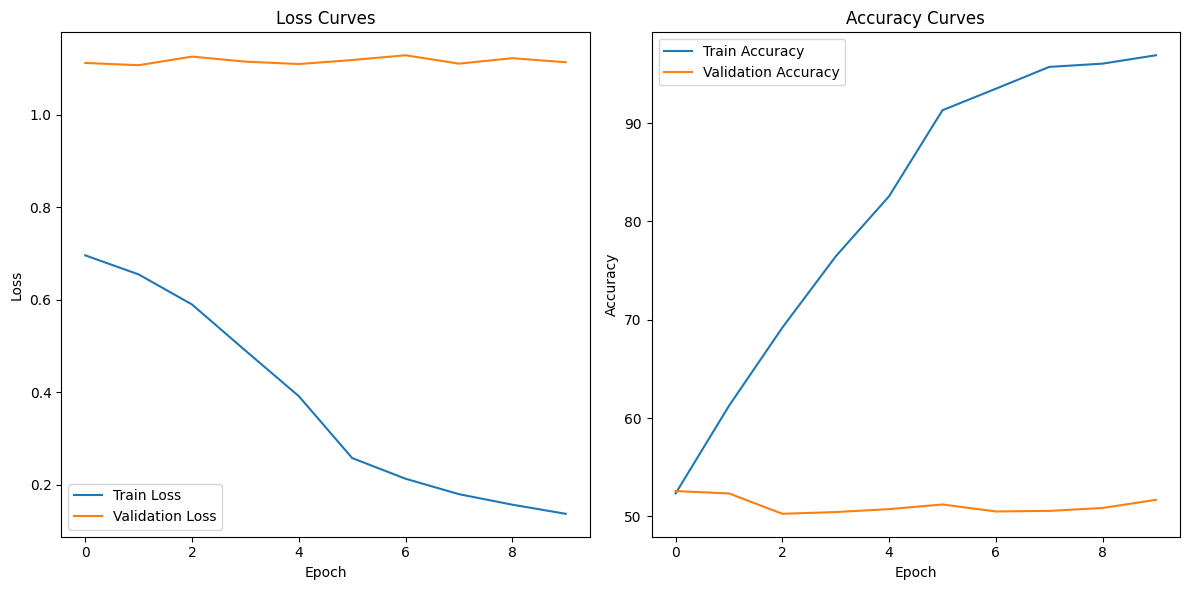

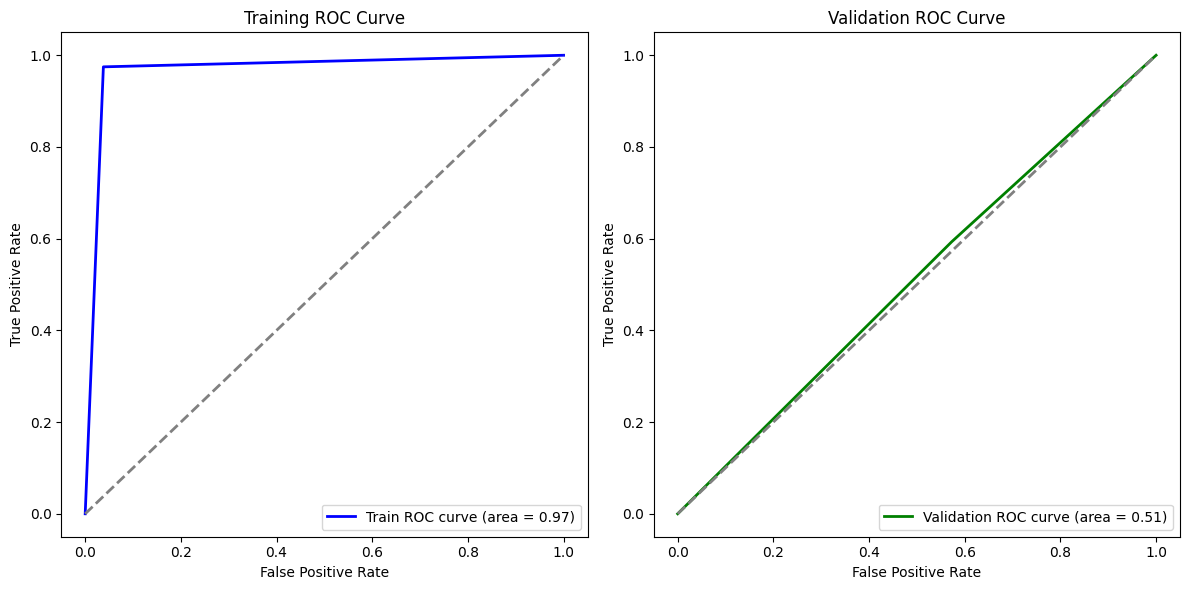

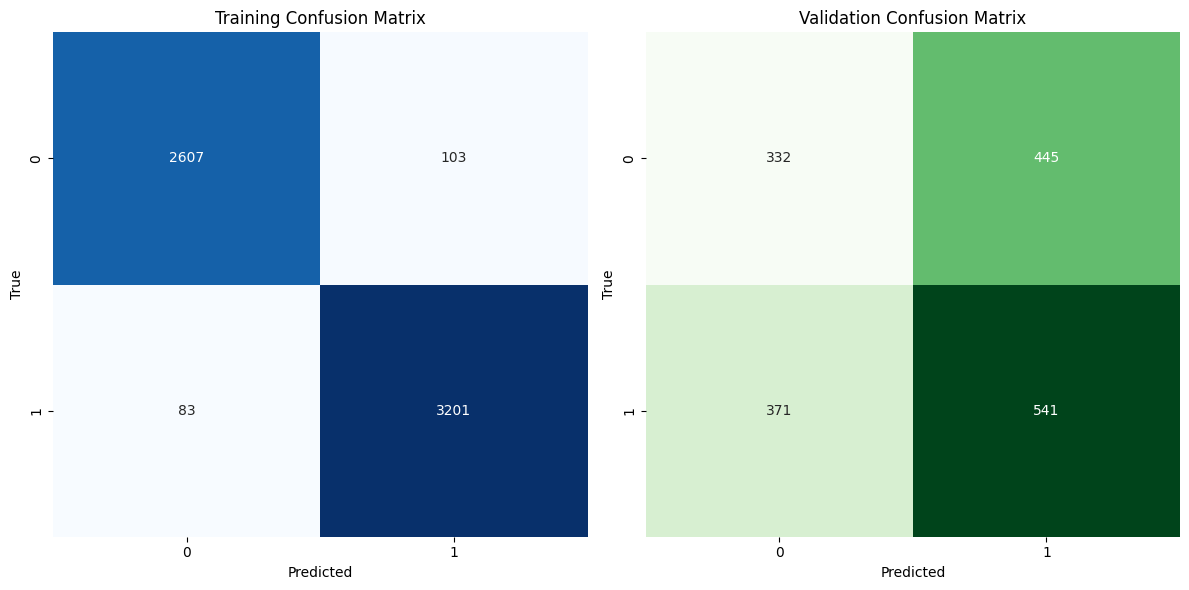

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Plotting the learning curves
plt.figure(figsize=(12, 6))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

# ROC curves for training and validation
plt.figure(figsize=(12, 6))

# Training ROC curve
plt.subplot(1, 2, 1)
fpr_train, tpr_train, _ = roc_curve(all_labels.ravel(), all_preds.ravel())
roc_auc_train = auc(fpr_train, tpr_train)
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (area = {roc_auc_train:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Training ROC Curve')
plt.legend(loc="lower right")

# Validation ROC curve
plt.subplot(1, 2, 2)
fpr_val, tpr_val, _ = roc_curve(val_labels.ravel(), val_preds.ravel())
roc_auc_val = auc(fpr_val, tpr_val)
plt.plot(fpr_val, tpr_val, color='green', lw=2, label=f'Validation ROC curve (area = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Confusion matrices for training and validation
plt.figure(figsize=(12, 6))

# Training confusion matrix
plt.subplot(1, 2, 1)
cm_train = confusion_matrix(all_labels.ravel(), all_preds.ravel())
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Training Confusion Matrix')

# Validation confusion matrix
plt.subplot(1, 2, 2)
cm_val = confusion_matrix(val_labels.ravel(), val_preds.ravel())
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Validation Confusion Matrix')

plt.tight_layout()
plt.show()

In [13]:
# Print Final Metrics
print("\nFinal Metrics:")
print(f"Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.2f}%")
print(f"Training ROC AUC: {roc_auc_train:.4f}")
print(f"Validation ROC AUC: {roc_auc_val:.4f}")


Final Metrics:
Training Loss: 0.1368, Training Accuracy: 96.90%
Validation Loss: 1.1132, Validation Accuracy: 51.69%
Training ROC AUC: 0.9684
Validation ROC AUC: 0.5102


In [14]:
from google.colab import files

# Save the model locally
torch.save(model.state_dict(), 'dbt_resnet50.pth')

# Download the file
files.download('dbt_resnet50.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
from google.colab import files

torch.save(model, 'model_full.pth')


files.download('model_full.pth')  # or 'model_full.pth'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

plot the precision, recall, and F1 score over the training epochs

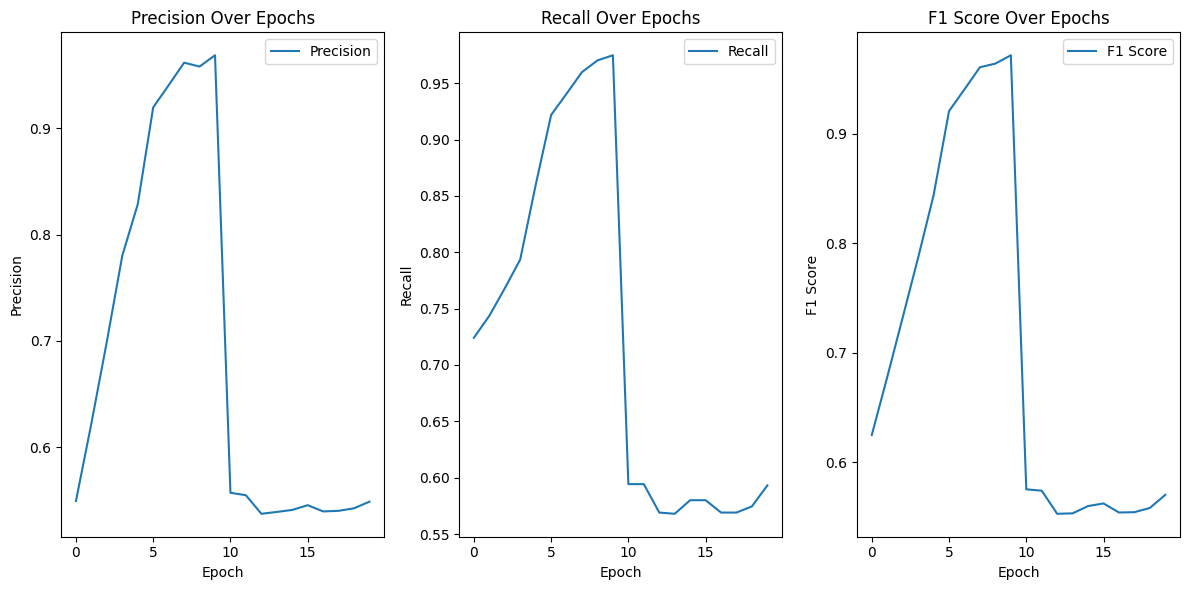

In [17]:
# Plot Precision, Recall, and F1 Score over epochs
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision Over Epochs')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(recall, label='Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall Over Epochs')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(f1, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
import pandas as pd

# Create a table of final metrics
metrics = {
    'Metric': ['Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy', 'Training ROC AUC', 'Validation ROC AUC'],
    'Value': [train_losses[-1], val_losses[-1], train_accuracies[-1], val_accuracies[-1], roc_auc_train, roc_auc_val]
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

                Metric      Value
0        Training Loss   0.136841
1      Validation Loss   1.113232
2    Training Accuracy  96.896897
3  Validation Accuracy  51.687389
4     Training ROC AUC   0.968359
5   Validation ROC AUC   0.510243


Percision -Recall curves for train and validation datasets

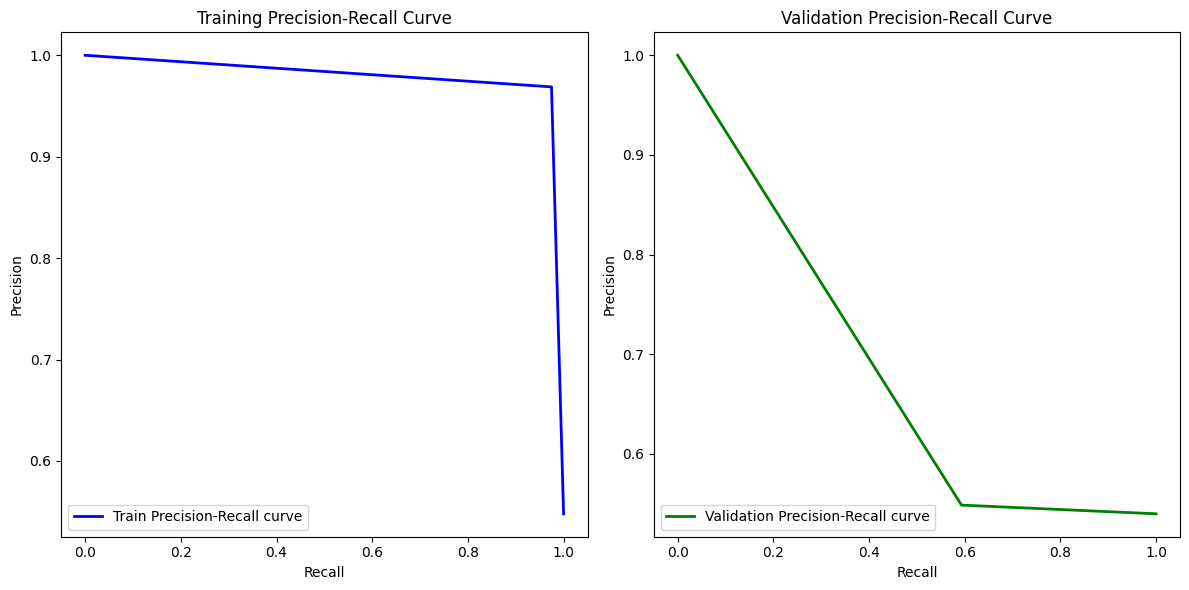

In [19]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall curve for training
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
precision_train, recall_train, _ = precision_recall_curve(all_labels.ravel(), all_preds.ravel())
plt.plot(recall_train, precision_train, color='blue', lw=2, label='Train Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Training Precision-Recall Curve')
plt.legend(loc="lower left")

# Precision-Recall curve for validation
plt.subplot(1, 2, 2)
precision_val, recall_val, _ = precision_recall_curve(val_labels.ravel(), val_preds.ravel())
plt.plot(recall_val, precision_val, color='green', lw=2, label='Validation Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Validation Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

create a heatmap to visualize the precision, recall, and F1 score for each class

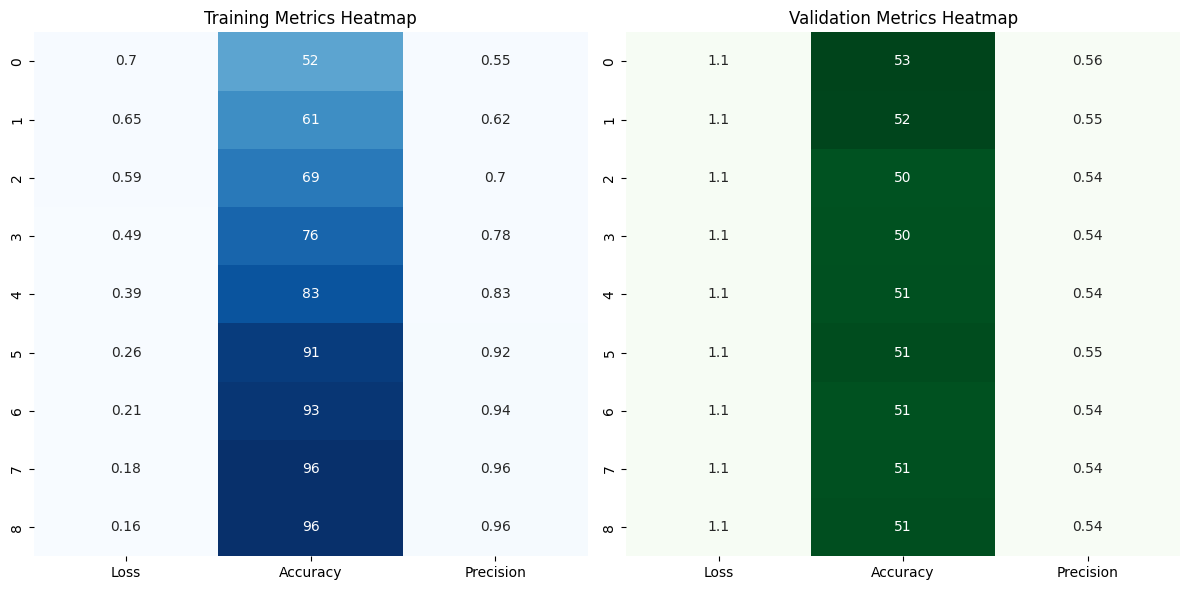

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create the train_metrics_df DataFrame
train_metrics_df = pd.DataFrame({
    'Loss': train_losses,
    'Accuracy': train_accuracies,
    'Precision': precision[:len(train_losses)],  # Adjust length if needed
    'Recall': recall[:len(train_losses)],      # Adjust length if needed
    'F1 Score': f1[:len(train_losses)],        # Adjust length if needed
    'ROC AUC': [roc_auc_train] * len(train_losses)  # Replicate ROC AUC for all epochs
})

# Create the val_metrics_df DataFrame # This is the added line
val_metrics_df = pd.DataFrame({
    'Loss': val_losses,
    'Accuracy': val_accuracies,
    'Precision': precision[len(train_losses):],  # Adjust length if needed
    'Recall': recall[len(train_losses):],      # Adjust length if needed
    'F1 Score': f1[len(train_losses):],        # Adjust length if needed
    'ROC AUC': [roc_auc_val] * len(val_losses)  # Replicate ROC AUC for all epochs
})

# Heatmap for training metrics
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(train_metrics_df.iloc[:-1, :3], annot=True, cmap='Blues', cbar=False)
plt.title('Training Metrics Heatmap')

# Heatmap for validation metrics
plt.subplot(1, 2, 2)
sns.heatmap(val_metrics_df.iloc[:-1, :3], annot=True, cmap='Greens', cbar=False)
plt.title('Validation Metrics Heatmap')

plt.tight_layout()
plt.show()

In [23]:
# Create a final table of metrics
final_metrics = {
    'Metric': ['Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy', 'Training ROC AUC', 'Validation ROC AUC', 'Training Precision', 'Validation Precision', 'Training Recall', 'Validation Recall', 'Training F1 Score', 'Validation F1 Score'],
    'Value': [train_losses[-1], val_losses[-1], train_accuracies[-1], val_accuracies[-1], roc_auc_train, roc_auc_val, precision[-1], precision_val, recall[-1], recall_val, f1[-1], f1_val]
}

final_metrics_df = pd.DataFrame(final_metrics)
print(final_metrics_df)

                  Metric                                          Value
0          Training Loss                                       0.136841
1        Validation Loss                                       1.113232
2      Training Accuracy                                      96.896897
3    Validation Accuracy                                      51.687389
4       Training ROC AUC                                       0.968359
5     Validation ROC AUC                                       0.510243
6     Training Precision                                       0.548682
7   Validation Precision  [0.5399644760213144, 0.5486815415821501, 1.0]
8        Training Recall                                       0.593202
9      Validation Recall                 [1.0, 0.5932017543859649, 0.0]
10     Training F1 Score                                       0.570074
11   Validation F1 Score                                       0.570074
